In [1]:
import torch
import torch.nn as nn

from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip
from torchvision import datasets

from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np

import time

In [2]:
def get_train_loader(data_dir,batch_size):
    normalize = Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    transform_d = Compose([ Resize((227,227)), ToTensor(), normalize, ])

    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_d)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

In [3]:
def get_test_loader(data_dir,  batch_size, shuffle=True):
    normalize = Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225], )

    transform = Compose([ Resize((227,227)), ToTensor(), normalize,])

    dataset = datasets.CIFAR10( root=data_dir, train=False, download=True, transform=transform,)

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [4]:
train_loader = get_train_loader(data_dir = './Cifar10', batch_size = 64)

test_loader = get_test_loader(data_dir = './Cifar10', batch_size = 64)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./Cifar10/cifar-10-python.tar.gz to ./Cifar10
Files already downloaded and verified


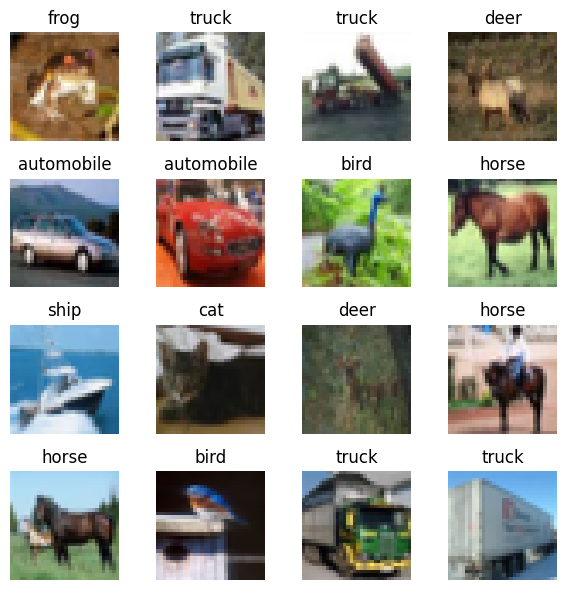

In [5]:
def show_images(X):

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))

    for i in range(4):
        for j in range(4):

            index = i * 4 + j
            axes[i, j].imshow(X.dataset.data[index], cmap=plt.cm.binary)
            axes[i, j].axis('off')
            axes[i, j].set_title(X.dataset.classes[X.dataset.targets[index]])
    plt.tight_layout()

    plt.show()

show_images(train_loader)

In [6]:
print("shape train", train_loader.dataset.data.shape)
print("shape test", test_loader.dataset.data.shape)

shape train (50000, 32, 32, 3)
shape test (10000, 32, 32, 3)


In [7]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=10):

        super(AlexNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [8]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

num_classes = 10
num_epochs = 30
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

cuda


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [10]:
graphic_loss = []
graphic_acc = []

In [11]:
for epoch in range(num_epochs):

    model.train()

    loss_list = []
    accuracy_list = []

    time_begin = time.time()

    for i, (images, labels) in enumerate(train_loader):

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        accuracy_list.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))

    time_end = time.time()
    deltaTime = time_end - time_begin

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Loss: {loss.item():.3f}, "
          f"Accuracy: {torch.stack(accuracy_list).mean():.4f}, "
          f"Time: {deltaTime:.2f} "
          )

    graphic_loss.append(torch.stack(loss_list).mean().cpu().detach().numpy())
    graphic_acc.append(torch.stack(accuracy_list).mean().cpu().detach().numpy())

Epoch 1/30, Loss: 1.249, Accuracy: 0.4954, Time: 103.09 
Epoch 2/30, Loss: 0.702, Accuracy: 0.6605, Time: 94.84 
Epoch 3/30, Loss: 1.192, Accuracy: 0.7193, Time: 95.14 
Epoch 4/30, Loss: 0.571, Accuracy: 0.7547, Time: 95.37 
Epoch 5/30, Loss: 0.374, Accuracy: 0.7830, Time: 94.73 
Epoch 6/30, Loss: 0.668, Accuracy: 0.7986, Time: 95.12 
Epoch 7/30, Loss: 0.792, Accuracy: 0.8158, Time: 95.48 
Epoch 8/30, Loss: 0.777, Accuracy: 0.8260, Time: 95.16 
Epoch 9/30, Loss: 0.453, Accuracy: 0.8408, Time: 94.96 
Epoch 10/30, Loss: 0.404, Accuracy: 0.8475, Time: 94.71 
Epoch 11/30, Loss: 0.281, Accuracy: 0.8569, Time: 95.22 
Epoch 12/30, Loss: 0.424, Accuracy: 0.8598, Time: 94.91 
Epoch 13/30, Loss: 0.264, Accuracy: 0.8683, Time: 95.17 
Epoch 14/30, Loss: 0.562, Accuracy: 0.8712, Time: 94.38 
Epoch 15/30, Loss: 0.313, Accuracy: 0.8746, Time: 95.00 
Epoch 16/30, Loss: 0.410, Accuracy: 0.8795, Time: 95.08 
Epoch 17/30, Loss: 0.419, Accuracy: 0.8796, Time: 95.62 
Epoch 18/30, Loss: 0.127, Accuracy: 0.8

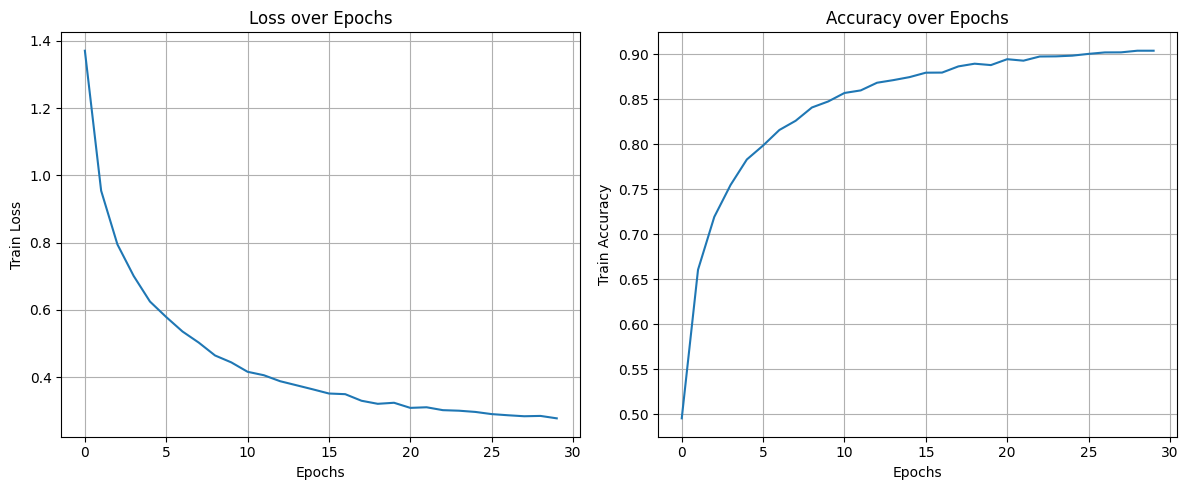

In [12]:
range_epoch = range(0, 30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range_epoch, graphic_loss)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss')
ax1.set_title('Loss over Epochs')
ax1.grid(True)

ax2.plot(range_epoch, graphic_acc)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Train Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [14]:
def test_acc():

    model.eval()

    correct = 0
    total = 0
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            test_acc += (predicted == labels).sum()

    print(f'Test loss: {loss / total:.5f}')
    print(f'Test accuracy (%): {100.*correct / total:.2f}%')

test_acc()

Test loss: 0.00008
Test accuracy (%): 81.64%
